In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import layers, models
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Replace 'path/to/your/file.csv' with the actual path to your CSV file
csv_file_path = '/content/drive/MyDrive/mnist_train.csv'

# Read data from CSV file into a pandas DataFrame
# Assuming the first column is the label column
df = pd.read_csv(csv_file_path, header=None)

# Split the data into features (X) and labels (y)
X = df.iloc[:, 1:]  # Features (all columns except the first one)
y = df.iloc[:, 0]   # Labels (the first column)

# Reshape the features to 28x28 images
X = X.values.reshape(-1, 28, 28, 1)

# Standardize pixel values
scaler = StandardScaler()
X = X.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
y= to_categorical(y, 10)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build a simplified version of GoogleNet for MNIST
def inception_module(x, filters):
    path1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(path3)
    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(path4)
    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def create_googlenet():
    input_layer = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 128, 128, 128, 192, 32])
    x = inception_module(x, [128, 192, 192, 192, 256, 64])

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output_layer = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Create and compile the model
googlenet_model = create_googlenet()
googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
googlenet_model.summary()
# Train the model
history = googlenet_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = googlenet_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 14, 14, 64)           3200      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)             0         ['conv2d_14[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_15 (Conv2D)          (None, 7, 7, 192)            110784    ['max_pooling2d_4[0][0]'

In [ ]:
from keras.models import load_model

# Save the model to a file
googlenet_model.save('/content/drive/MyDrive/Colab Notebooks/googlenet_model.h5')
print("Model saved successfully.")




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [ ]:
# from keras.models import load_model
# googlenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/googlenet_model.h5')

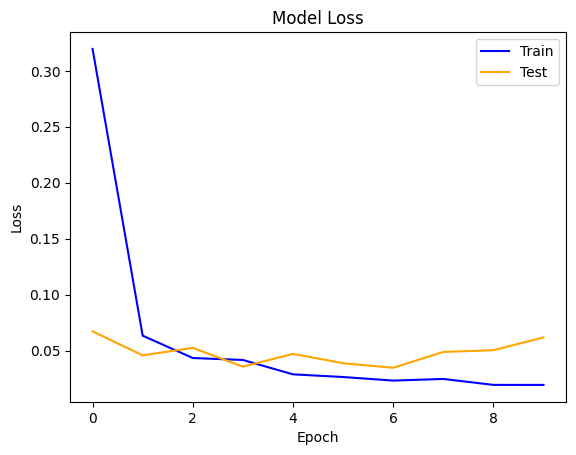

In [ ]:
import matplotlib.pyplot as plt
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

1/1 [==============================] - 0s 479ms/step


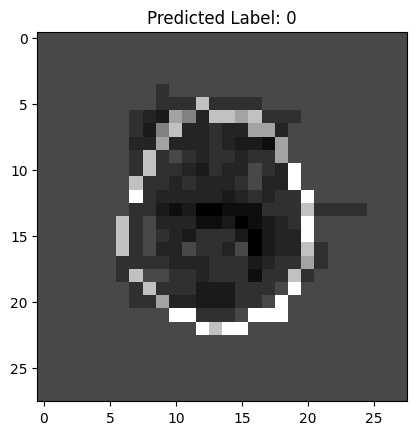

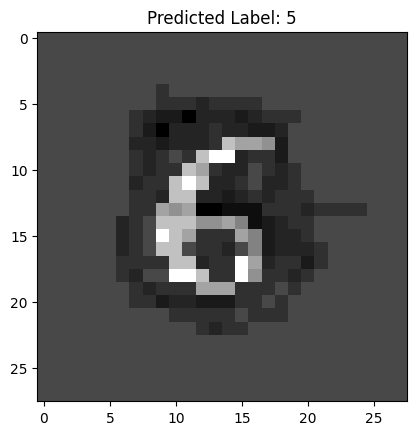

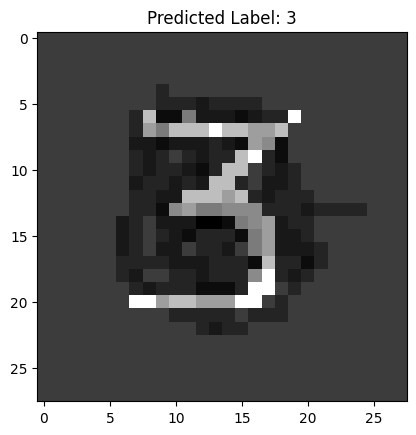

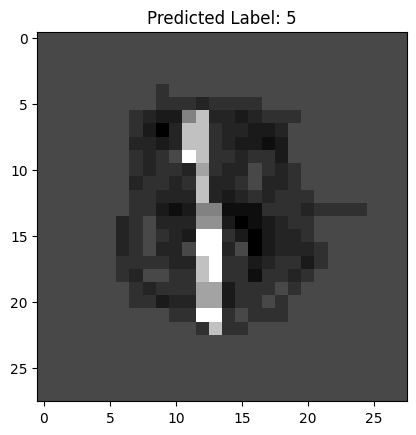

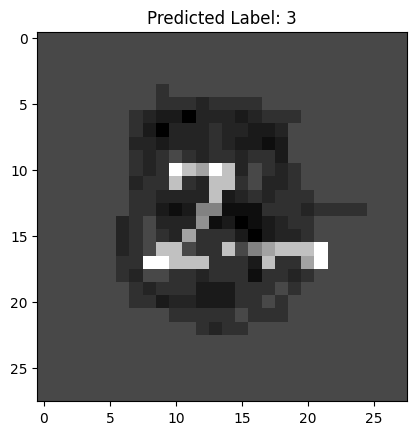

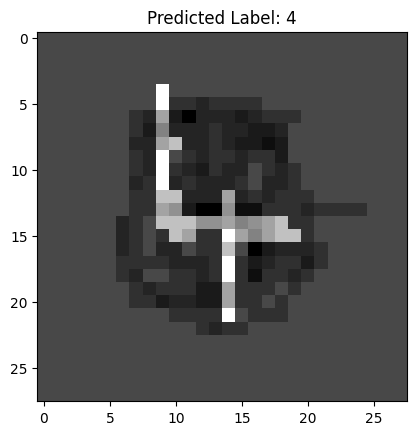

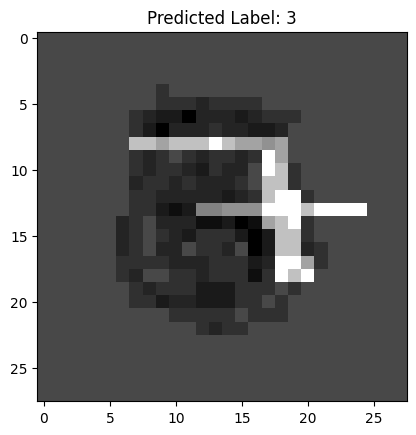

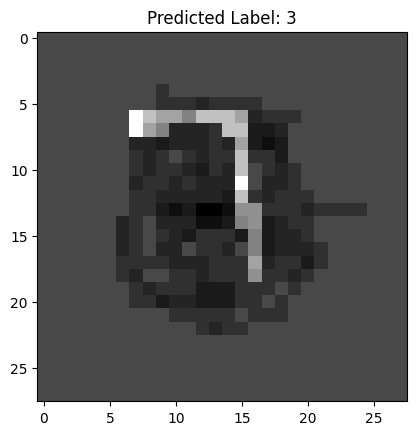

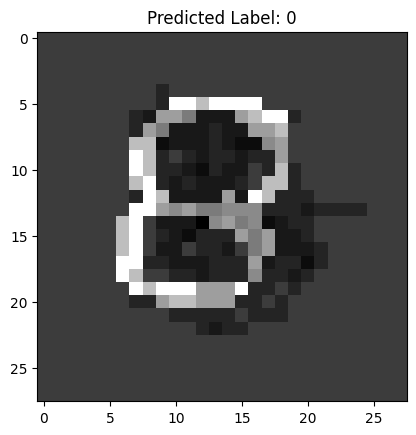

In [4]:
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from matplotlib import pyplot as plt

# Replace 'path/to/your/test_file.csv' with the actual path to your test CSV file
test_csv_file_path = '/content/drive/MyDrive/Colab Notebooks/test/output_data.csv'

# Load the saved VGG model
vgg_model = load_model('/content/drive/MyDrive/Colab Notebooks/googlenet_model.h5')

# Read data from the test CSV file into a pandas DataFrame
test_df = pd.read_csv(test_csv_file_path, header=None)

# Split the test data into features (X_test)
X_test = test_df.iloc[:, :]  # Features (all columns except the first one)

# Reshape the features to 28x28 images
X_test_images = X_test.values.reshape(-1, 28, 28, 1)

# Standardize pixel values using the same scaler as the training data
X_test_images = StandardScaler().fit_transform(X_test_images.reshape(-1, 784)).reshape(-1, 28, 28, 1)

# Make predictions on the test set using the loaded model
predictions = vgg_model.predict(X_test_images)

# Assuming you want the class with the highest probability as the predicted label
predicted_labels = np.argmax(predictions, axis=1)

# Loop through each image and its predicted label
for i in range(len(X_test_images)):
    # Display the image and its predicted label
    plt.imshow(X_test_images[i, :, :, 0], cmap='gray')
    plt.title(f'Predicted Label: {predicted_labels[i]}')
    plt.show()
